# RNA velocity: Analysis of kinetics parameters

This notebooks is complementary to **Bergen et al. (2021)**, ***RNA velocity: Current challenges and future perspectives***, and provides several insights on applicability of RNA velocity when kinetic parameters are time-dependent.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scvelo as scv

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
scv.set_figure_params(dpi=60, fontsize=16, facecolor='none')  # set dpi=200 to generate high-res figures
scv.settings.verbosity = 0  # set to 3 to see more information
scv.logging.print_version()

Running scvelo 0.2.4.dev48+gfeae560.d20210809 (python 3.8.0) on 2021-08-09 23:44.


## Simulations with varying kinetic rate parameters

varying transcription rate $\alpha$ (increasing from l to r)

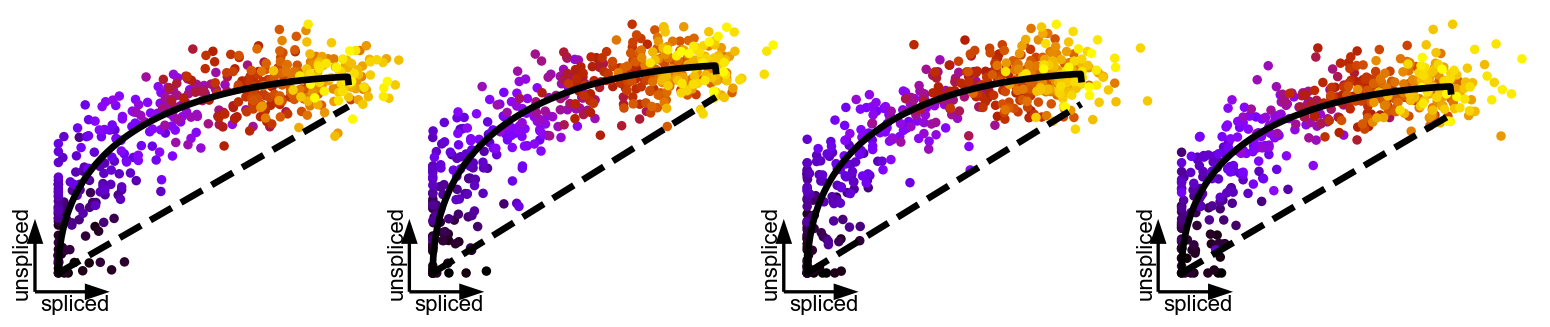

varying splicing rate $\beta$ (increasing from l to r)

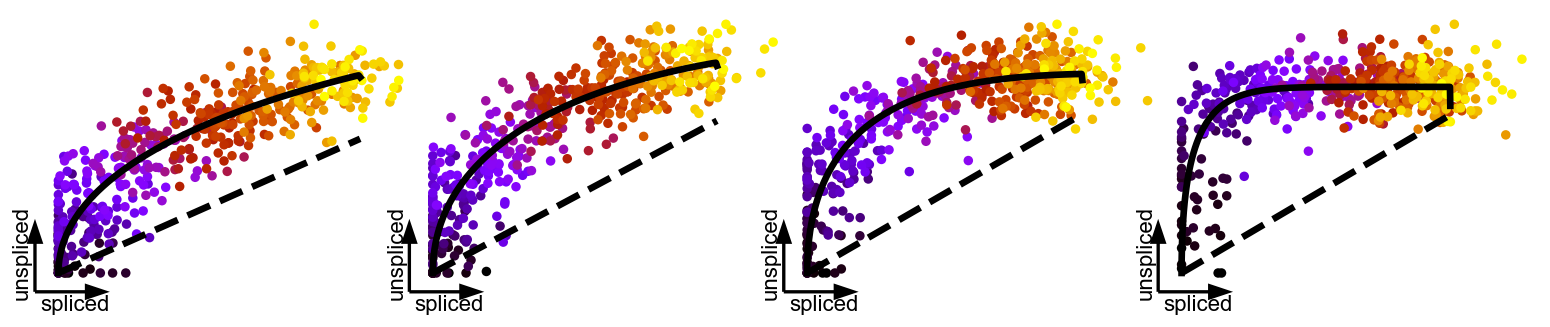

varying degradation rate $\gamma$ (increasing from l to r)

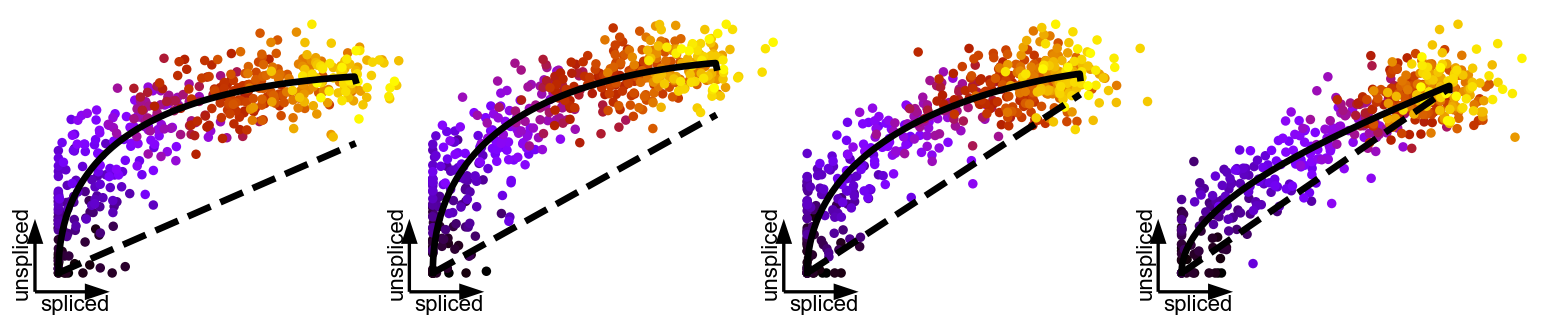

varying $\beta$ and $\gamma$ simulatenously (increasing at same scale from l to r)

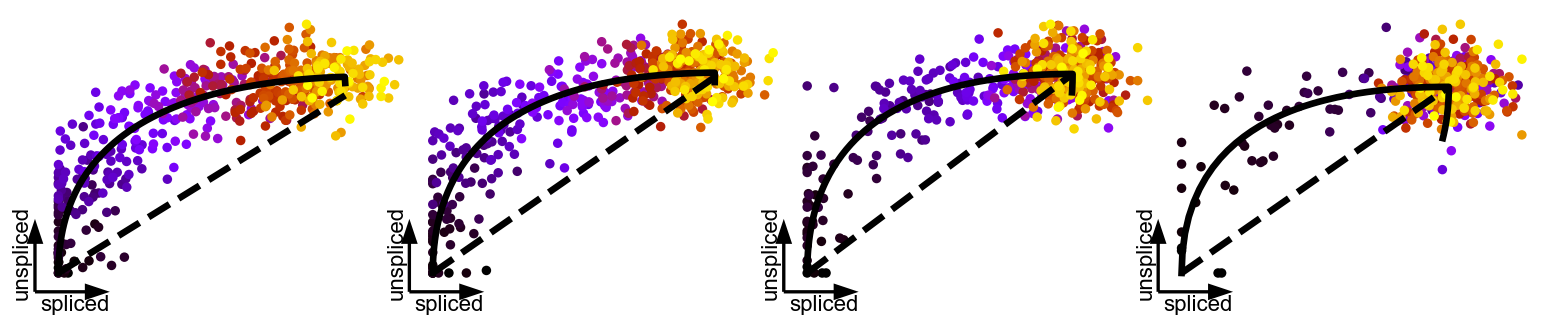

varying all three kinetic rate parameters (increasing at same scale from l to r)

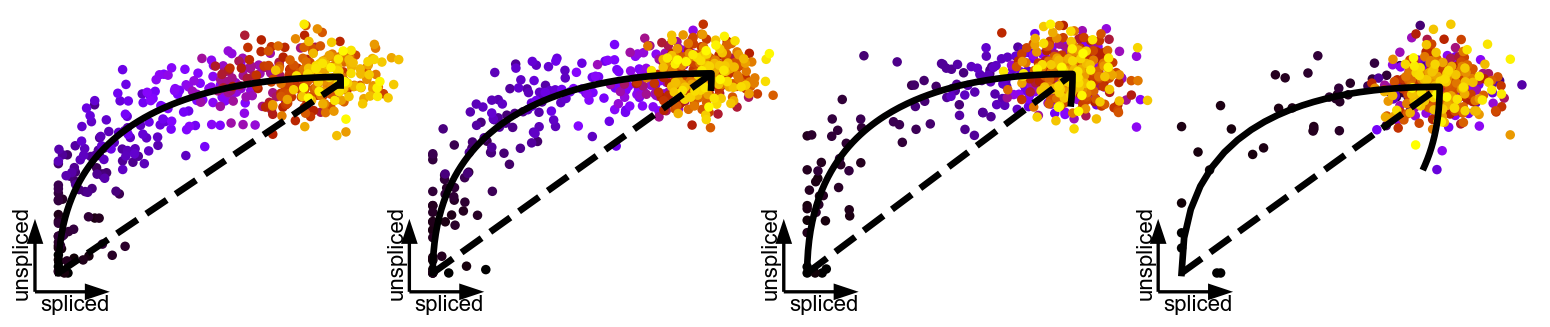

In [4]:
from scvelo.datasets import simulation

plt_kwargs = dict(
    vkey='true_dynamics', 
    use_raw=True, 
    linewidth=8, 
    frameon='artist', 
    title='', 
    c='true_t', 
    cmap='gnuplot', 
    colorbar=False,
    wspace=0, 
    figsize=(4,3),
)

n_obs, n_vars = 500, 20
sim_kwargs = dict(n_obs=n_obs, n_vars=n_vars, switches=1, noise_level=1)

def plot_scatter(adata, var_names):
    scv.pp.neighbors(adata)
    scv.tl.velocity(adata, use_raw=True)
    scv.pl.scatter(adata, adata.var_names[[1, 2, 5, -1]], **plt_kwargs)


# varying alpha
printmd(r'varying transcription rate $\alpha$ (increasing from l to r)')
f = np.linspace(1, 35, n_vars)
adata = simulation(t_max=25, alpha=f*5, beta=.2, gamma=.1, **sim_kwargs)
plot_scatter(adata, adata.var_names[[1, 2, 5, -1]])


# varying beta
printmd(r'varying splicing rate $\beta$ (increasing from l to r)')
f = np.linspace(0.2, 5, n_vars)
adata = simulation(t_max=20, alpha=5, beta=f*.2, gamma=.1, **sim_kwargs)
plot_scatter(adata, adata.var_names[[1,3,6,10]])


# varying gamma
printmd(r'varying degradation rate $\gamma$ (increasing from l to r)')
f = np.linspace(0.5, 5, n_vars)
adata = simulation(t_max=20, alpha=5, beta=.2, gamma=f*.1, **sim_kwargs)
plot_scatter(adata, adata.var_names[[1,5,10,15]])


# varying beta and gamma
printmd(r'varying $\beta$ and $\gamma$ simulatenously (increasing at same scale from l to r)')
f = np.linspace(1, 20, n_vars)
adata = simulation(t_max=15, alpha=5, beta=f*.2, gamma=f*.1, **sim_kwargs)
plot_scatter(adata, adata.var_names[[1, 2, 5, -1]])


# varying alpha, beta and gamma simulatenously
printmd('varying all three kinetic rate parameters (increasing at same scale from l to r)')
f = np.linspace(1, 35, n_vars)
adata = simulation(t_max=15, alpha=f*5, beta=f*.2, gamma=f*.1, **sim_kwargs)
plot_scatter(adata, adata.var_names[[1, 2, 5, -1]])

varying the ratio $\frac{\beta}{\gamma+\beta}$ = {[0.14 0.31 0.52 0.73]}

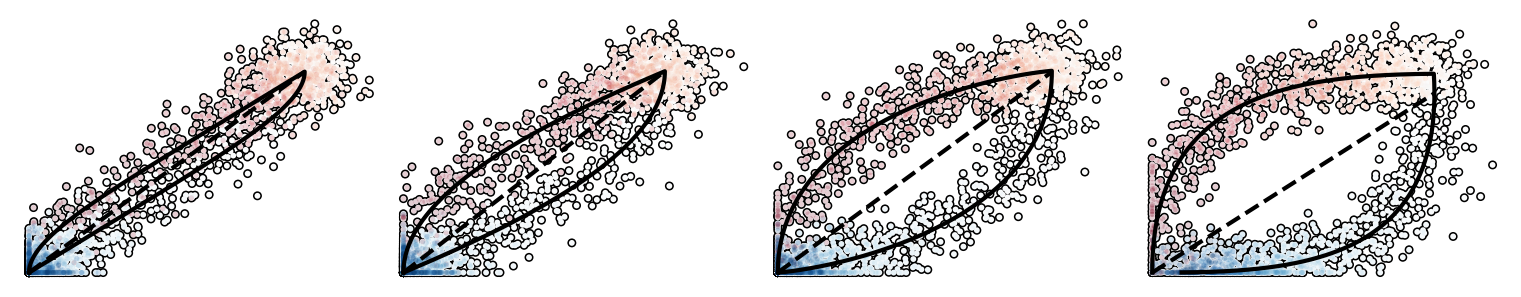

In [5]:
plt_kwargs = dict(
    vkey='true_dynamics', 
    use_raw=True, 
    linewidth=5, 
    linecolor='black', 
    alpha=.2, 
    add_outline=True,
    frameon=False, 
    title='', 
    c='true_t', 
    cmap='RdBu', 
    colorbar=False,
    wspace=0, 
    figsize=(4,3),
)

alpha = 5
beta = .15
f = np.linspace(.1, .9, 20)
gamma = beta * (1 / f - 1)  # so that the ratio beta/(gamma+beta) constantly increases. 

adata = scv.datasets.simulation(n_obs=2000, n_vars=len(f), t_max=100, switches=.5, alpha=alpha, beta=beta, gamma=gamma, noise_level=.8)
scv.pp.neighbors(adata)
scv.tl.velocity(adata, use_raw=True)

printmd(r'varying the ratio $\frac{\beta}{\gamma+\beta}$ = {%s}' % np.round((beta/(gamma + beta))[[1, 5, 10, 15]], 2))
scv.pl.scatter(adata, adata.var_names[[1, 5, 10, 15]], **plt_kwargs)

## Kinetic signal (overall curvature) with time-dependent rates

In [6]:
from scipy.integrate import odeint, quad
cmap = matplotlib.cm.get_cmap('magma')

import numpy as np
exp = np.exp

a, b, c, d, l = 2, .3, .2, .25, .5
t = np.linspace(0,100, num=1000)

def model(z, t, alpha, b, c, d, l):
    if np.isinf(l):
        l = 1e8
    a, u, s = z  
    a = alpha
    dadt = 0  # sol: a = alpha
    dudt = a - b * u
    dsdt = d * u - c * s
    dzdt = [dadt,dudt,dsdt]
    return dzdt

def model_alpha(z, t, alpha, b, c, d, l):
    if np.isinf(l):
        l = 1e8
    a, u, s = z    
    dadt = l*(alpha - a)  # sol: a(t) = a0 * exp(-l*t) + alpha * (1 - exp(-l*t))
    dudt = a - b * u
    dsdt = d * u - c * s
    dzdt = [dadt,dudt,dsdt]
    return dzdt

def model_beta(z, t, a, beta, c, d, l):
    if np.isinf(l):
        l = 1e6
    b, u, s = z
    dbdt = l*(beta - b)  # sol: b(t) = b0 * exp(-l*t) + beta * (1 - exp(-l*t))
    dudt = a - b * u
    dsdt = b/beta*d * u - c * s
    dzdt = [dbdt,dudt,dsdt]
    return dzdt

def model_gamma(z, t, a, b, gamma, d, l):
    l = 1e8 if np.isinf(l) else l
    c, u, s = z
    dcdt = l*(gamma - c)  # sol: c(t) = c0 * exp(-l*t) + gamma * (1 - exp(-l*t))
    dudt = a - b * u
    dsdt = d * u - c * s
    dzdt = [dcdt,dudt,dsdt]
    return dzdt

def unspliced(t, l):  # solution for time-variable a(t) = alpha * (1 - exp(-l*t))
    return a/b*(1-exp(-b*t)) + a/(l-b)*(exp(-l*t)-exp(-b*t))

def spliced(t, l):    # solution for time-variable a(t) = alpha * (1 - exp(-l*t))
    return (a*d)/(b*c)*(1-exp(-c*t)) + (d*a)/(b*(c-b))*(exp(-c*t)-exp(-b*t)) + (a*d)/(l-b) * ((exp(-c*t)-exp(-b*t))/(c-b)-(exp(-c*t)-exp(-l*t))/(c-l))

def kinetic_signal_ode(l, b, c):
    def integrand(t):  # integral of: residual * ds/dt dt, where residual = u - c/d * s
        u = a/b*(1-exp(-b*t)) + a/(l-b)*(exp(-l*t)-exp(-b*t))
        s = (a*d)/(b*c)*(1-exp(-c*t)) + (d*a)/(b*(c-b))*(exp(-c*t)-exp(-b*t)) + (a*d)/(l-b) * ((exp(-c*t)-exp(-b*t))/(c-b)-(exp(-c*t)-exp(-l*t))/(c-l))
        resi = u - c/d * s
        dsdt = d * u - c * s
        return resi * dsdt
    return quad(integrand, 0, np.infty)[0]

def kinetic_signal(l, b, c):  # closed form solution of `kinetic_signal_ode`
    c_const = .5 * a/b * (d*a)/(b*c) * (b/(c+b))
    c_lamda = 1 - (b*c)/((l+c)*(l+b))
    return c_const * c_lamda

sol_ode = kinetic_signal_ode(l, b, c)
sol_exact = kinetic_signal(l, b, c)

# check that the exact and ODE solution are the same
print(np.round(sol_ode, 6), np.round(sol_exact, 6))

14.880952 14.880952


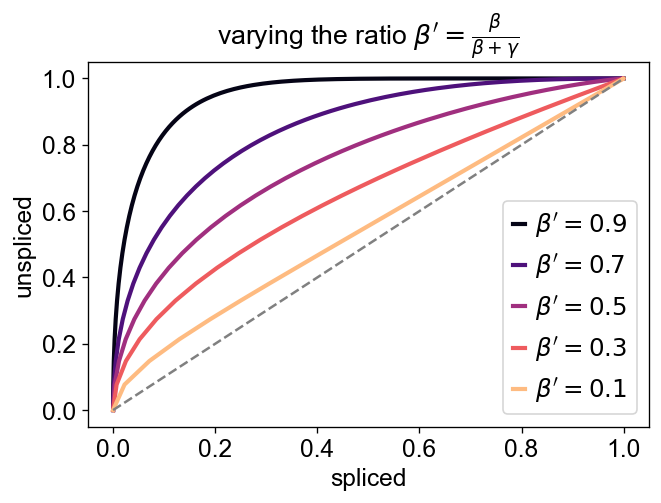

In [7]:
# varying beta and gamma
a, b, c, d, l = 2, .8, .2, .25, np.infty

f = np.linspace(.1, .9, 5)
gamma = (b * (1 / f - 1))[::-1]  # so that the ratio beta/(gamma+beta) linearly increases. 

z0 = [0,0,0]
for i, c in enumerate(gamma):
    z = odeint(model, z0, t, args=(a, b, c, d, l))
    alpha, u, s = z.T
    u /= np.max(u)
    s /= np.max(s)
    plt.plot(s, u, c=cmap((i+.2)/(len(gamma)-.1)), linewidth=2.5)
plt.legend([r"$\beta'={%s}$" %r for r in np.round(b/(b+gamma), 1)])
plt.title(r"varying the ratio $\beta'=\frac{\beta}{\beta+\gamma}$")
plt.xlabel('spliced')
plt.ylabel('unspliced')
plt.plot([0, 1],[0, 1], '--', c='grey', )

plt.show()

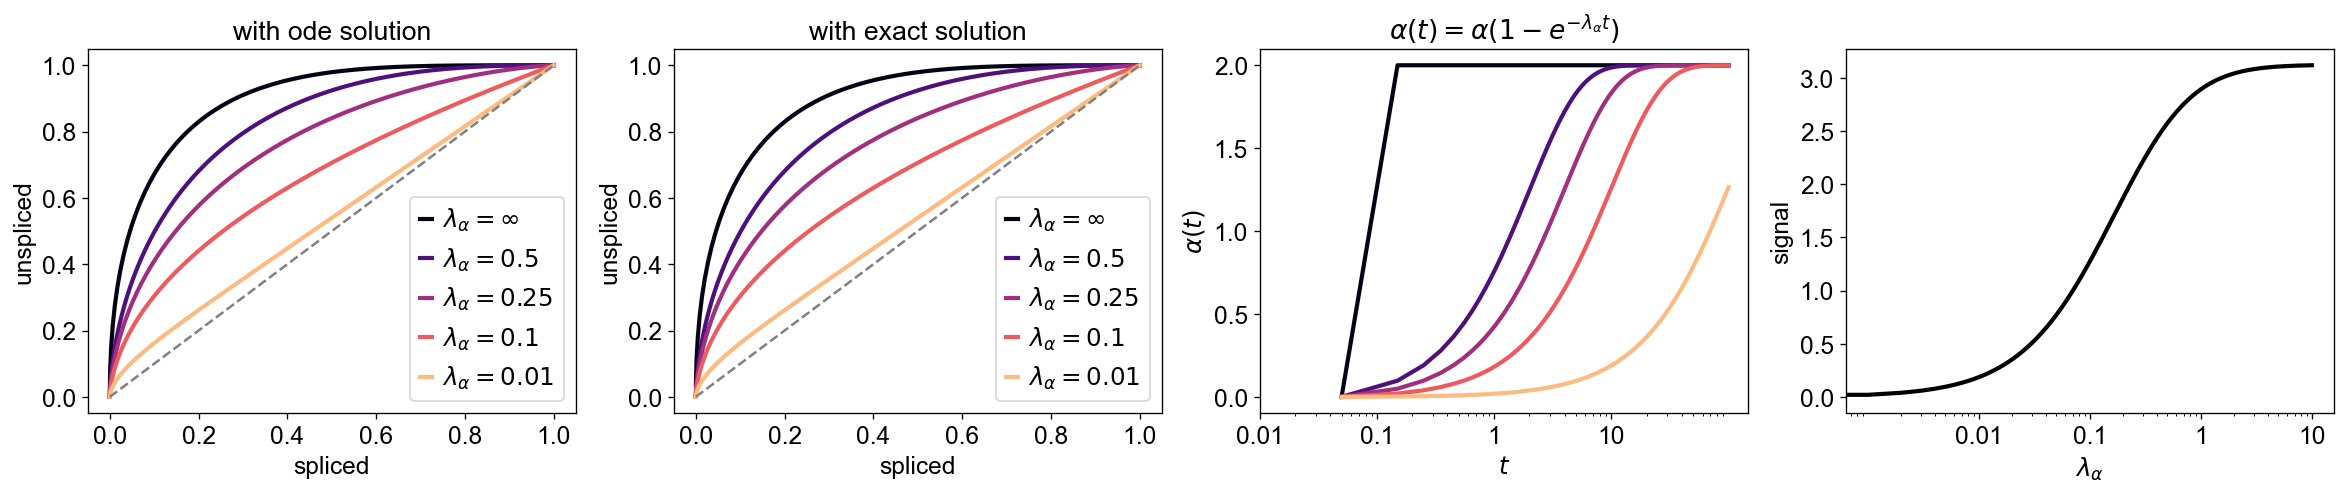

In [8]:
# varying the timescale parameter
gs = scv.pl.gridspec(4)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

a, b, c, d, l = 2, .8, .2, .25, .5
t = np.linspace(0.05,100, num=1000)

z0 = [0,0,0]
l_vals = [0.01, 0.1, 0.25, 0.5, np.infty][::-1]


for i, l in enumerate(l_vals):
    z = odeint(model_alpha, z0, t, args=(a, b, c, d, l))
    alpha, u, s = z.T
    u /= np.max(u)
    s /= np.max(s)
    ax1.plot(s, u, c=cmap((i+.2)/(len(l_vals)-.1)), linewidth=2.5)
    
    ax3.plot(t, alpha, c=cmap((i+.2)/(len(l_vals)-.1)), linewidth=2.5)
    
ax1.plot([0, 1],[0, 1], '--', c='grey', )

l_vals_legend = ["\infty" if np.isinf(l) else l for l in l_vals]
ax1.legend([fr'$\lambda_\alpha={l}$' for l in l_vals_legend])
ax1.set_title('with ode solution')
ax1.set_xlabel('spliced')
ax1.set_ylabel('unspliced')

for i, l in enumerate(l_vals):
    u = unspliced(t, l)
    s = spliced(t, l)
    u /= np.max(u)
    s /= np.max(s)
    ax2.plot(s, u, c=cmap((i+.2)/(len(l_vals)-.1)), linewidth=2.5)

ax2.plot([0, 1],[0, 1], '--', c='grey', )

l_vals_legend = ["\infty" if np.isinf(l) else l for l in l_vals]
ax2.legend([fr'$\lambda_\alpha={l}$' for l in l_vals_legend])
ax2.set_title('with exact solution')
ax2.set_xlabel('spliced')
ax2.set_ylabel('unspliced')

ax3.set_title(r'$\alpha(t) = \alpha (1-e^{-\lambda_\alpha t})$')
ax3.set_xlabel(r'$t$')
ax3.set_ylabel(r'$\alpha(t)$')
ax3.set_xscale('log')
ticks = [0.01, 0.1, 1, 10]
ax3.set_xticks(ticks)
ax3.get_xaxis().set_major_formatter(matplotlib.ticker.FixedFormatter(ticks))

scale = np.linspace(0, 10, num=10000)
ax4.plot(scale, kinetic_signal(scale, b, c), c='k', linewidth=2.5)
ax4.set_xscale('log')

ticks = [0.01, 0.1, 1, 10]
ax4.set_xticks(ticks)
ax4.get_xaxis().set_major_formatter(matplotlib.ticker.FixedFormatter(ticks))

ax4.set_xlabel(r'$\lambda_\alpha$')
ax4.set_ylabel('signal')
plt.show()

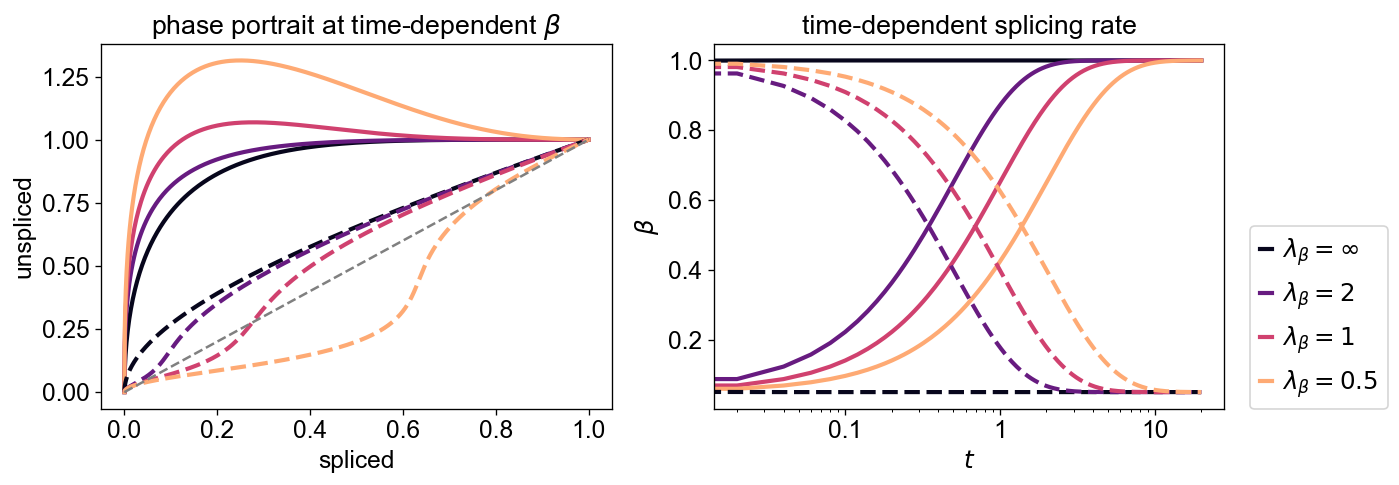

Decreasing (solid) and increasing (dashed) splicing rate.


In [14]:
gs = scv.pl.gridspec(2)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

a, b, c, d, l = 2, .5, .2, .25, .5
t = np.linspace(0,20, num=1000)

b = 1
z0 = [.05,0,0]  # beta increasing from 1 to 5.
l_vals = [.5, 1, 2, np.infty][::-1]
for i, l in enumerate(l_vals):
    z = odeint(model_beta, z0, t, args=(a, b, c, d, l))
    beta_inc, u, s = z.T
    s /= np.max(s)
    u /= u[np.argmax(s)]
    ax.plot(s, u, c=cmap((i+.2)/(len(l_vals)-.1)), linewidth=2.5)
    ax2.plot(t, beta_inc, c=cmap((i+.2)/(len(l_vals)-.1)), linewidth=2.5)

l_vals_legend = ["\infty" if np.isinf(l) else l for l in l_vals]

b = .05
z0 = [1,0,0]   # beta decreasing from 5 to 1.
for i, l in enumerate(l_vals):
    z = odeint(model_beta, z0, t, args=(a, b, c, d, l))
    beta_dec, u, s = z.T
    u /= np.max(u)
    s /= s[np.argmax(u)]
    ax.plot(s, u, '--', c=cmap((i+.2)/(len(l_vals)-.1)), linewidth=2.5)
    ax2.plot(t, beta_dec, '--', c=cmap((i+.2)/(len(l_vals)-.1)), linewidth=2.5)
    
ax.plot([0, 1],[0, 1], '--', c='grey', )

ax.set_title(r'phase portrait at time-dependent $\beta$')
ax.set_xlabel('spliced')
ax.set_ylabel('unspliced')



ax2.set_title('time-dependent splicing rate')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$\beta$')
ax2.set_xscale('log')

ticks = [0.1, 1, 10]
ax2.set_xticks(ticks)
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FixedFormatter(ticks))

l_vals_legend = ["\infty" if np.isinf(l) else l for l in l_vals]
ax2.legend([fr'$\lambda_\beta={l}$' for l in l_vals_legend], bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)


plt.show()

print('Decreasing (solid) and increasing (dashed) splicing rate.')

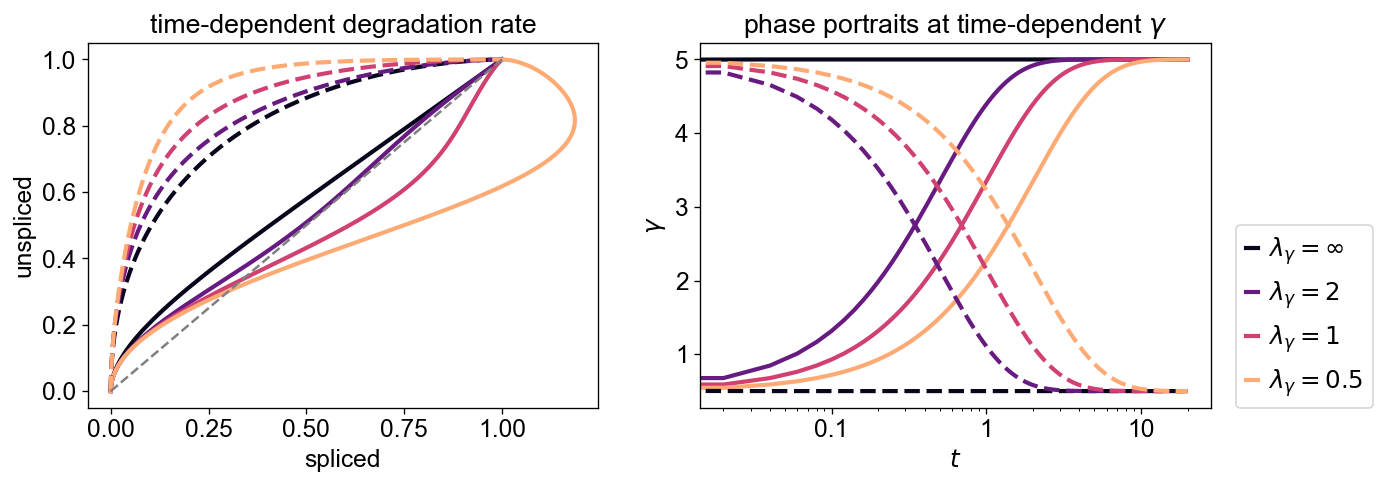

Increasing (solid) and decreasing (dashed) degradation rate.


In [15]:
gs = scv.pl.gridspec(2)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

a, b, c, d, l = 2, .8, .2, .25, .5
t = np.linspace(0, 20, num=1000)

c = 5
z0 = [.5,0,0]  # gamma increasing from 1 to 5.
l_vals = [.5, 1, 2, np.infty][::-1]
for i, l in enumerate(l_vals):
    z = odeint(model_gamma, z0, t, args=(a, b, c, d, l))
    gamma_inc, u, s = z.T
    u /= np.max(u)
    s /= s[np.argmax(u)]
    ax.plot(s, u, c=cmap((i+.2)/(len(l_vals)-.1)), linewidth=2.5)
    ax2.plot(t, gamma_inc, c=cmap((i+.2)/(len(l_vals)-.1)), linewidth=2.5)

l_vals_legend = ["\infty" if np.isinf(l) else l for l in l_vals]

c = .5
z0 = [5,0,0]   # gamma decreasing from 5 to 1.
l_vals = [.5, 1, 2, np.infty][::-1]
for i, l in enumerate(l_vals):
    z = odeint(model_gamma, z0, t, args=(a, b, c, d, l))
    gamma_dec, u, s = z.T
    u /= np.max(u)
    s /= s[np.argmax(u)]
    ax.plot(s, u, '--', c=cmap((i+.2)/(len(l_vals)-.1)), linewidth=2.5)
    ax2.plot(t, gamma_dec, '--', c=cmap((i+.2)/(len(l_vals)-.1)), linewidth=2.5)
    
ax.plot([0, 1],[0, 1], '--', c='grey', )

ax.set_title('time-dependent degradation rate')
ax.set_xlabel('spliced')
ax.set_ylabel('unspliced')

ax2.set_title(r'phase portraits at time-dependent $\gamma$')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$\gamma$')
ax2.set_xscale('log')

ticks = [0.1, 1, 10]
ax2.set_xticks(ticks)
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FixedFormatter(ticks))

l_vals_legend = ["\infty" if np.isinf(l) else l for l in l_vals]
ax2.legend([fr'$\lambda_\gamma={l}$' for l in l_vals_legend], bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)


plt.show()

print('Increasing (solid) and decreasing (dashed) degradation rate.')

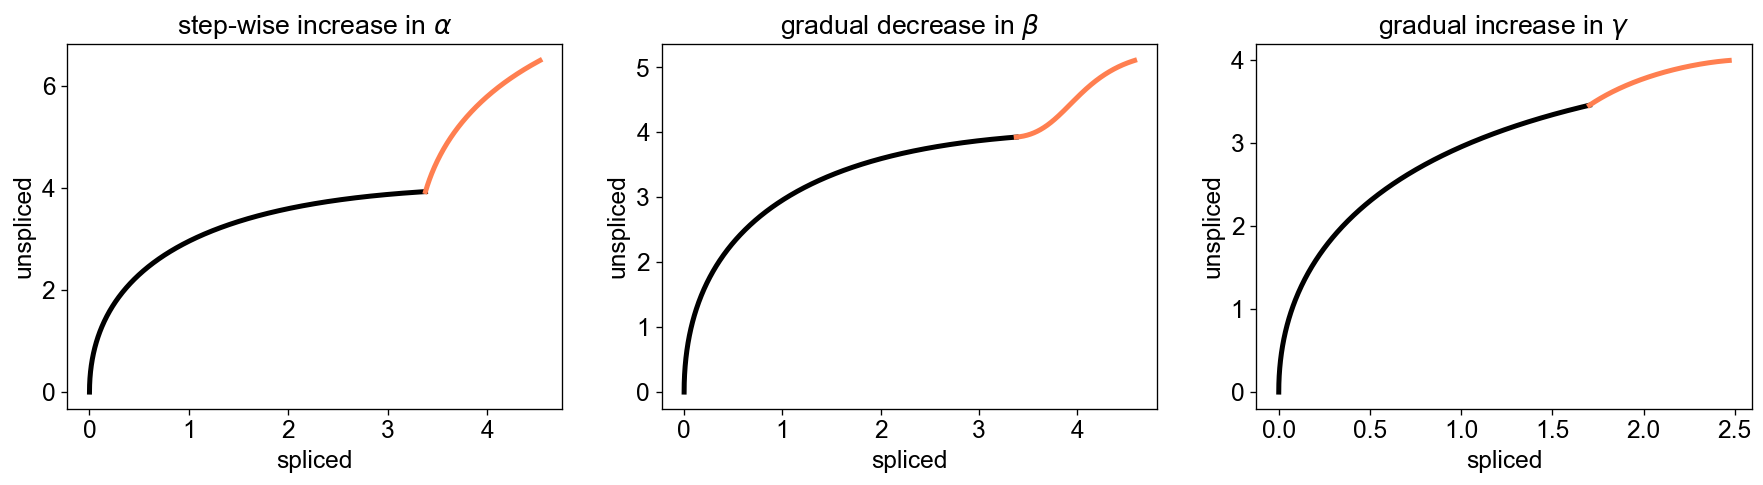

In [16]:
gs = scv.pl.gridspec(3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

a, b, c, d, l = 2, .5, .2, .25, .5
t = np.linspace(0,10, num=1000)

z0 = [0,0,0]
z1 = odeint(model, z0, t[:800], args=(a, b, c, d, l))
alpha1, u1, s1 = z1.T

z0 = [0, u1.max(), s1.max()]
z2 = odeint(model, z0, t[:200], args=(a*2, b, c, d, l))
alpha2, u2, s2 = z2.T

ax1.plot(s1, u1, c='k', linewidth=3)
ax1.plot(s2, u2, c='coral', linewidth=3)


z0 = [0,0,0]
z1 = odeint(model, z0, t[:800], args=(a, b, c, d, l))
alpha1, u1, s1 = z1.T

z0 = [b, u1.max(), s1.max()]
z2 = odeint(model_beta, z0, t[:1000], args=(a, b/1.3, c, d/1.3, .5))
alpha2, u2, s2 = z2.T

ax2.plot(s1, u1, c='k', linewidth=3)
ax2.plot(s2, u2, c='coral', linewidth=3)


z0 = [0,0,0]
z1 = odeint(model, z0, t[:400], args=(a, b, c, d, l))
alpha1, u1, s1 = z1.T

z0 = [c, u1.max(), s1.max()]
z2 = odeint(model, z0, t[:1000], args=(a, b, c*2, d, .1))
alpha2, u2, s2 = z2.T

ax3.plot(s1, u1, c='k', linewidth=3)
ax3.plot(s2, u2, c='coral', linewidth=3)


ax1.set_title(r'step-wise increase in $\alpha$')
ax2.set_title(r'gradual decrease in $\beta$')
ax3.set_title(r'gradual increase in $\gamma$')

for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('unspliced')
    ax.set_xlabel('spliced')

plt.show()